In [1]:
import torch
import torch.nn as nn 
import torch.nn.functional as f 
from sklearn.model_selection import train_test_split 
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [2]:
data = pd.read_csv('mnist_train.csv')
data = data.values

In [3]:
labels = data[:,0]
data = data[:,1:]


In [4]:
#dataBin = np.where(data > 128, 1, 0) 

# alternative
dataBin = (data>0).astype(float)

In [5]:
print(np.unique(data))
print(np.unique(dataBin))

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

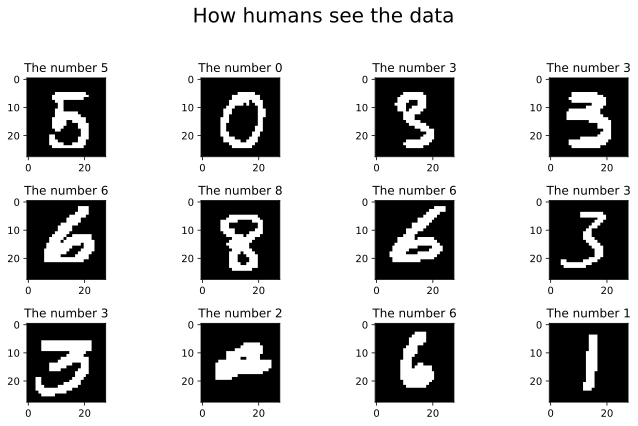

In [6]:
fig, axs = plt.subplots(3,4, figsize = (10,6))

for ax in axs.flatten():

    # pick a random image
    randimg2show = np.random.randint(0, high = data.shape[0])

    # create the image 
    img = np.reshape(dataBin[randimg2show, :], (28,28) )
    ax.imshow(img, cmap = 'gray')

    # title 
    ax.set_title('The number %i' %labels[randimg2show])

plt.suptitle('How humans see the data', fontsize = 20)
plt.tight_layout(rect = [0,0,1,.95])
plt.show()

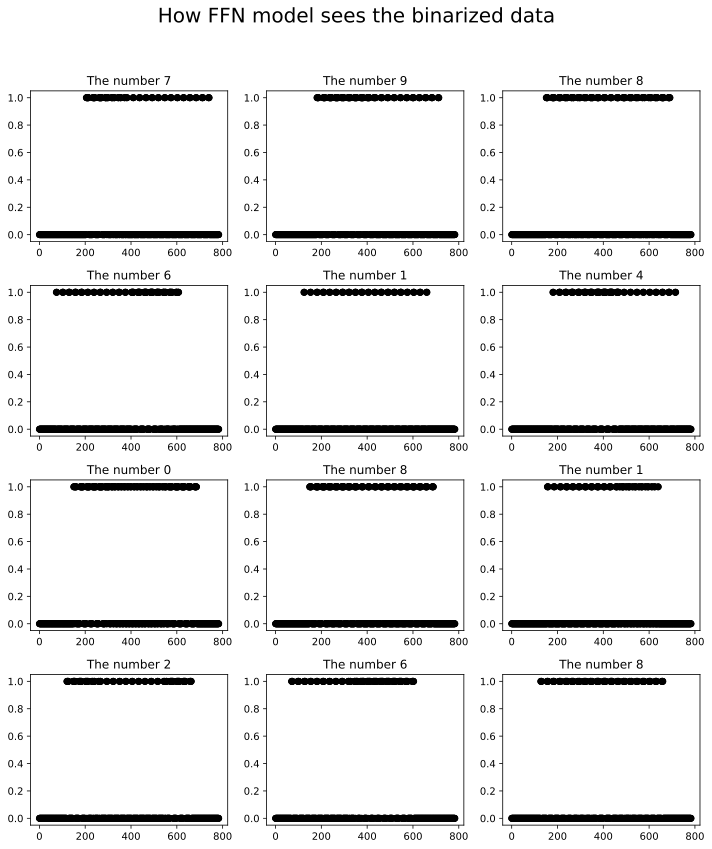

In [7]:
fig, axs = plt.subplots(4,3, figsize = (10,12))

for ax in axs.flatten():

    randomimg2show = np.random.randint(0, high = dataBin.shape[0])


    ax.plot(dataBin[randomimg2show,:], 'ko')

    ax.set_title(f'The number {labels[randomimg2show]}')
plt.suptitle('How FFN model sees the binarized data', fontsize = 20)
plt.tight_layout(rect = [0,0,1,.95])
plt.show()

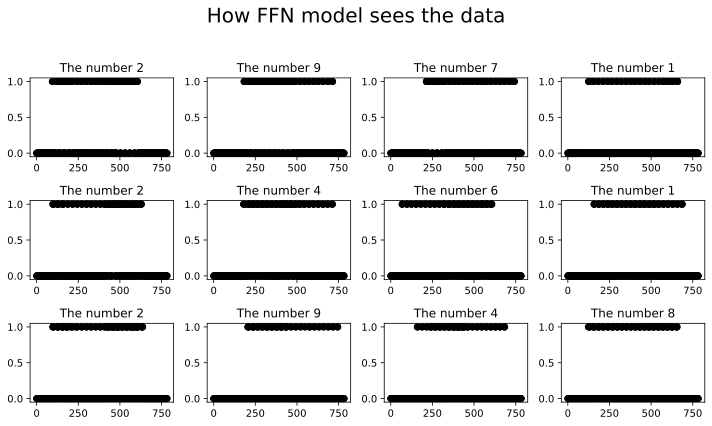

In [8]:
# show a few random digits 
fig, axs = plt.subplots(3, 4, figsize = (10, 6))

for ax in axs.flatten():
    randimg2show = np.random.randint(0, high = data.shape[0])

    # create the image  
    ax.plot(dataBin[randimg2show,:], 'ko')

    # title 
    ax.set_title('The number %i' %labels[randimg2show])

plt.suptitle('How FFN model sees the data', fontsize = 20)
plt.tight_layout(rect = [0,0,1,.95])
plt.show()

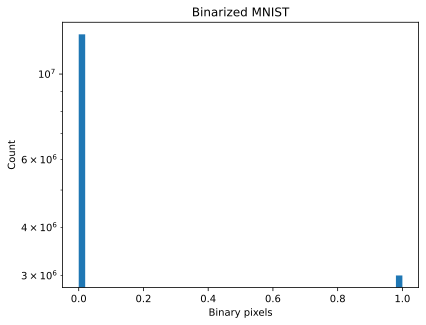

In [9]:
plt.hist(dataBin.flatten(), 50)
plt.yscale('log')
plt.xlabel('Binary pixels')
plt.ylabel('Count')
plt.title('Binarized MNIST')
plt.show()


In [10]:
# converting data to tensor
dataT = torch.tensor(dataBin).float()
labelsT = torch.tensor(labels).long()

In [11]:
# train and test Split
train_data, test_data, train_labels, test_labels = train_test_split(dataT, labelsT, test_size = .2)

# Tensor dataset
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

# Data Loaders 
train_loader = DataLoader(train_data, batch_size = 32)
test_loader = DataLoader(test_data, batch_size = len(test_data))

In [12]:
def createMNISTnet():

    class MNISTnet(nn.Module):

        def __init__(self):
            super().__init__()

            # input layer 
            self.input = nn.Linear(784, 64)

            # hidden layer 
            self.fc1 = nn.Linear(64, 32)
            self.fc2 = nn.Linear(32, 32)

            # output layer 
            self.output = nn.Linear(32, 10)

        def forward(self, X):

            X = f.relu(self.input(X))
            X = f.relu(self.fc1(X))
            X = f.relu(self.fc2(X))

            return torch.log_softmax(self.output(X), axis = 1)
        
    
    net = MNISTnet()

    # loss function 
    lossfun = nn.NLLLoss()

    # optimizer 
    optimizer = torch.optim.Adam(net.parameters(), lr = .01)

    return net, lossfun, optimizer

            

            

In [13]:
# testing
n, l, o = createMNISTnet()
n, l, o

(MNISTnet(
   (input): Linear(in_features=784, out_features=64, bias=True)
   (fc1): Linear(in_features=64, out_features=32, bias=True)
   (fc2): Linear(in_features=32, out_features=32, bias=True)
   (output): Linear(in_features=32, out_features=10, bias=True)
 ),
 NLLLoss(),
 Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     lr: 0.01
     maximize: False
     weight_decay: 0
 ))

In [14]:

def function2TrainModel():

    numepochs = 60
    net, lossfun, optimizer = createMNISTnet()

    testAcc = []
    trainAcc = []
    losses = np.zeros(numepochs)

    for i in range(numepochs):
        
        # switching on training mode
        net.train()

        # keeping track of losses and accuracy(batch-wise) 
        batchLoss = []
        batchAcc = []

        for X, y in train_loader:

            # forward pass and calculation of loss
            yHat = net(X)
            loss = lossfun(yHat, y)
            # appending the loss 
            batchLoss.append(loss.item())

            # backward propogation 
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            

            # calculating the accuracy
            matches = (torch.argmax(yHat, axis = 1) == y).float()
            accuracyPct = 100*torch.mean(matches)
            batchAcc.append(accuracyPct)


        # taking the mean of batch loss and batch accuracy        
        losses[i] = np.mean(batchLoss)
        trainAcc.append(np.mean(batchAcc))

        # evaluating each epoch
        net.eval()
        X, y = next(iter(test_loader))
        with torch.inference_mode():
            yHat = net(X)
            loss = lossfun(yHat, y)
            # calculating the accuracy
            matches = (torch.argmax(yHat, axis = 1) == y).float()
            accuracyPct = 100*torch.mean(matches)
            testAcc.append(accuracyPct)
        
    return trainAcc, testAcc, losses, net




In [15]:
trainAcc, testAcc, losses, net = function2TrainModel()

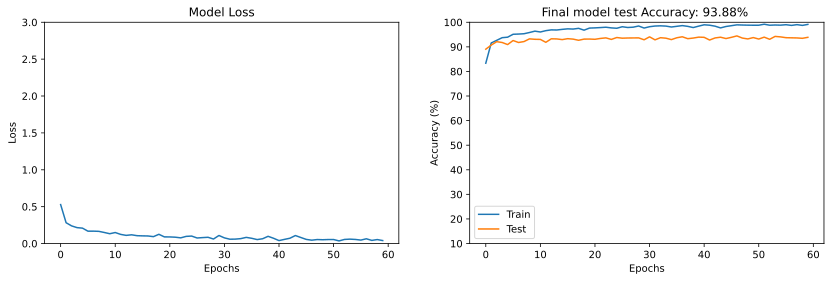

In [16]:
fig, ax = plt.subplots(1,2, figsize = (14,4))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title('Model Loss')

ax[1].plot(trainAcc, label = 'Train')
ax[1].plot(testAcc, label = 'Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f'Final model test Accuracy: {testAcc[-1]:.2f}% ')
ax[1].legend()

plt.show()